# Model Comparison – LightGBM vs XGBoost vs Prophet

Mục tiêu: So sánh 3 mô hình theo Step 7 tổng kết (two-stage GBDT vs Prophet) trên tập test.
- Dữ liệu: `data/processed/fe_weekly_gross.csv`
- Split: train ≤ 2011-06-01, val 2011-06→2011-09, test 2011-09→2011-12
- Metrics: Accuracy (clf), MAE, RMSE, WAPE, SMAPE
- Biểu đồ: đường thời gian y_true vs y_pred theo SKU, và tổng hợp


In [26]:
# Setup & Imports
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path('..')
DATA_PROCESSED = ROOT / 'data' / 'processed'
FE_PATH = DATA_PROCESSED / 'fe_weekly_gross.csv'
PRED_DIR = DATA_PROCESSED / 'predictions'
PRED_DIR.mkdir(parents=True, exist_ok=True)

WEEK_FREQ = 'W-MON'
TRAIN_END = pd.Timestamp('2011-06-01')
VAL_END = pd.Timestamp('2011-09-01')

print('Paths ready')


Paths ready


In [27]:
# Metrics

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom[denom == 0] = 1.0
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def wape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.sum(np.abs(y_true))
    if denom == 0:
        return np.nan
    return np.sum(np.abs(y_pred - y_true)) / denom

def mape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(eps, np.abs(y_true))))

def regression_report(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': rmse,
        'WAPE': wape(y_true, y_pred),
        'SMAPE': smape(y_true, y_pred)
    }


In [28]:
# Load FE and prepare splits/features
fe = pd.read_csv(FE_PATH, parse_dates=['InvoiceDate'])
fe = fe.sort_values(['StockCode','InvoiceDate']).reset_index(drop=True)
fe['label_has_sale'] = (fe['y'] > 0).astype(int)

# no-leakage features
drop_cols = {'InvoiceDate','StockCode','Country','y','label_has_sale','Quantity', 'Price'}
feature_cols = [c for c in fe.columns if c not in drop_cols]

train_idx = fe['InvoiceDate'] < TRAIN_END
val_idx = (fe['InvoiceDate'] >= TRAIN_END) & (fe['InvoiceDate'] < VAL_END)
test_idx = fe['InvoiceDate'] >= VAL_END

X_train, y_train_cls = fe.loc[train_idx, feature_cols], fe.loc[train_idx, 'label_has_sale']
X_val, y_val_cls = fe.loc[val_idx, feature_cols], fe.loc[val_idx, 'label_has_sale']
X_test, y_test_cls = fe.loc[test_idx, feature_cols], fe.loc[test_idx, 'label_has_sale']

# regression positive-only
pos_train = fe[train_idx & (fe['y'] > 0)]
pos_val = fe[val_idx & (fe['y'] > 0)]
pos_test = fe[test_idx & (fe['y'] > 0)]

X_train_reg, y_train_reg = pos_train[feature_cols], pos_train['y']
X_val_reg, y_val_reg = pos_val[feature_cols], pos_val['y']
X_test_reg, y_test_reg = pos_test[feature_cols], pos_test['y']

print('Ready, features:', len(feature_cols))


Ready, features: 31


Test leakage

In [29]:
# Leakage diagnostics – sanity checks on features vs labels
from sklearn.metrics import roc_auc_score

# 1) Ensure no forbidden columns in features
forbidden = {'y','Quantity','label_has_sale','has_sale'}
violations = [c for c in feature_cols if c in forbidden or c.lower().endswith('has_sale')]
print('Forbidden in feature_cols:', violations)

# 2) Check if any single feature equals label on VAL/TEST
suspects = []
for c in feature_cols:
    s_val = (fe.loc[val_idx, c]).values
    s_test = (fe.loc[test_idx, c]).values
    # binaryization for certain checks
    if pd.api.types.is_numeric_dtype(s_val):
        bin_val = (pd.Series(s_val).fillna(0) > 0).astype(int).values
        bin_test = (pd.Series(s_test).fillna(0) > 0).astype(int).values
        if (bin_val == y_val_cls.values).all() and len(y_val_cls) > 0:
            suspects.append((c,'val','bin==label'))
        if (bin_test == y_test_cls.values).all() and len(y_test_cls) > 0:
            suspects.append((c,'test','bin==label'))
    # exact equality
    if pd.Series(s_val).equals(pd.Series(y_val_cls)):
        suspects.append((c,'val','exact'))
    if pd.Series(s_test).equals(pd.Series(y_test_cls)):
        suspects.append((c,'test','exact'))
print('Exact/binary equality suspects:', suspects)

# 3) AUC per-feature (VAL) for binary proxies
auc_rows = []
for c in feature_cols:
    x = pd.Series(fe.loc[val_idx, c]).astype(float)
    if x.isna().all():
        continue
    try:
        # convert to monotonically increasing rank to avoid degenerate ties
        r = x.rank(method='average').fillna(0).values
        auc = roc_auc_score(y_val_cls, r)
        if auc > 0.999 or auc < 0.001:
            auc_rows.append((c, auc))
    except Exception:
        pass
print('Suspicious AUC features (VAL):', auc_rows[:15])

# 4) Focused probes commonly leaking
probes = {
    'weeks_since_last_sale==0': (fe.loc[:, 'weeks_since_last_sale']==0).astype(int),
    'qty_lag_1>0': (fe.loc[:, 'qty_lag_1']>0).astype(int),
    'zero_rate_8w==0': (fe.loc[:, 'zero_rate_8w']==0).astype(int),
    'zero_rate_8w==1': (fe.loc[:, 'zero_rate_8w']==1).astype(int),
}
for name, series in probes.items():
    try:
        auc_val = roc_auc_score(y_val_cls, series.loc[val_idx])
        auc_test = roc_auc_score(y_test_cls, series.loc[test_idx])
        print(f'{name}: AUC VAL={auc_val:.4f}, TEST={auc_test:.4f}')
    except Exception:
        pass

# 5) Show cross-tab for top probe on VAL/TEST
probe = (fe['qty_lag_1']>0).astype(int)
print('VAL crosstab qty_lag_1>0 vs label:\n', pd.crosstab(probe.loc[val_idx], y_val_cls))
print('TEST crosstab qty_lag_1>0 vs label:\n', pd.crosstab(probe.loc[test_idx], y_test_cls))


Forbidden in feature_cols: []
Exact/binary equality suspects: []
Suspicious AUC features (VAL): []
weeks_since_last_sale==0: AUC VAL=0.7465, TEST=0.7450
qty_lag_1>0: AUC VAL=0.7465, TEST=0.7450
zero_rate_8w==0: AUC VAL=0.6975, TEST=0.7317
zero_rate_8w==1: AUC VAL=0.3944, TEST=0.4096
VAL crosstab qty_lag_1>0 vs label:
 label_has_sale      0      1
qty_lag_1                   
0               10975   5034
1                4627  18897
TEST crosstab qty_lag_1>0 vs label:
 label_has_sale     0      1
qty_lag_1                  
0               6823   5265
1               3672  27624


In [30]:
# Train LightGBM (two-stage)

lgb_cls = lgb.LGBMClassifier(n_estimators=2000, learning_rate=0.05, num_leaves=63, subsample=0.8, colsample_bytree=0.8, random_state=42)
lgb_reg = lgb.LGBMRegressor(n_estimators=3000, learning_rate=0.03, num_leaves=127, subsample=0.8, colsample_bytree=0.8, random_state=42)

lgb_cls.fit(X_train, y_train_cls,
            eval_set=[(X_val, y_val_cls)],
            eval_metric='binary_logloss',
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)])

lgb_reg.fit(X_train_reg, y_train_reg,
            eval_set=[(X_val_reg, y_val_reg)],
            eval_metric='l2',
            callbacks=[lgb.early_stopping(150), lgb.log_evaluation(200)])

# Predict on test
y_prob_lgb = lgb_cls.predict_proba(X_test)[:,1]
y_hat_cls_lgb = (y_prob_lgb >= 0.5).astype(int)

y_reg_pred_lgb = lgb_reg.predict(X_test)
y_pred_lgb = np.where(y_hat_cls_lgb==1, np.maximum(0.0, y_reg_pred_lgb), 0.0)

acc_lgb = accuracy_score(y_test_cls, y_hat_cls_lgb)
print('LGBM Accuracy (clf):', round(float(acc_lgb),4))


[LightGBM] [Info] Number of positive: 140761, number of negative: 105110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data points in the train set: 245871, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572499 -> initscore=0.292056
[LightGBM] [Info] Start training from score 0.292056
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.429454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5571
[LightGBM] [Info] Number of data points in the train set: 140761, number of used features: 31
[LightGBM] [Info] Start training from score 54.268967
Training until validatio

In [31]:
# Train XGBoost via DMatrix (two-stage)

dtrain_cls = xgb.DMatrix(X_train, label=y_train_cls)
dval_cls = xgb.DMatrix(X_val, label=y_val_cls)
dtest_cls = xgb.DMatrix(X_test)

params_cls = {'objective': 'binary:logistic','eval_metric': 'logloss','max_depth': 8,'eta': 0.05,'subsample': 0.8,'colsample_bytree': 0.8,'tree_method':'hist','seed':42}

bst_cls = xgb.train(params_cls, dtrain_cls, num_boost_round=2000, evals=[(dval_cls,'valid')], early_stopping_rounds=100, verbose_eval=200)

dtrain_reg = xgb.DMatrix(X_train_reg, label=y_train_reg)
dval_reg = xgb.DMatrix(X_val_reg, label=y_val_reg)
dtest_reg = xgb.DMatrix(X_test)

params_reg = {'objective':'reg:squarederror','eval_metric':'rmse','max_depth':8,'eta':0.03,'subsample':0.8,'colsample_bytree':0.8,'tree_method':'hist','seed':42}

bst_reg = xgb.train(params_reg, dtrain_reg, num_boost_round=3000, evals=[(dval_reg,'valid')], early_stopping_rounds=150, verbose_eval=200)

# Predict
prob_xgb = bst_cls.predict(dtest_cls, iteration_range=(0, getattr(bst_cls,'best_iteration', None)+1 if getattr(bst_cls,'best_iteration', None) is not None else None))
y_hat_cls_xgb = (prob_xgb >= 0.5).astype(int)

reg_pred_xgb = bst_reg.predict(dtest_reg, iteration_range=(0, getattr(bst_reg,'best_iteration', None)+1 if getattr(bst_reg,'best_iteration', None) is not None else None))
y_pred_xgb = np.where(y_hat_cls_xgb==1, np.maximum(0.0, reg_pred_xgb), 0.0)

acc_xgb = accuracy_score(y_test_cls, y_hat_cls_xgb)
print('XGB Accuracy (clf):', round(float(acc_xgb),4))


[0]	valid-logloss:0.65297
[200]	valid-logloss:0.42700
[215]	valid-logloss:0.42736
[0]	valid-rmse:112.91167
[166]	valid-rmse:175.28188
XGB Accuracy (clf): 0.836


LGBM: {'MAE': 36.723975476055045, 'RMSE': 108.4804592069532, 'WAPE': np.float64(0.7280002668730047), 'SMAPE': np.float64(0.8953691130806284)}
XGB : {'MAE': 48.123690871499505, 'RMSE': 122.55435686505434, 'WAPE': np.float64(0.9539833131684969), 'SMAPE': np.float64(0.9743597239379732)}


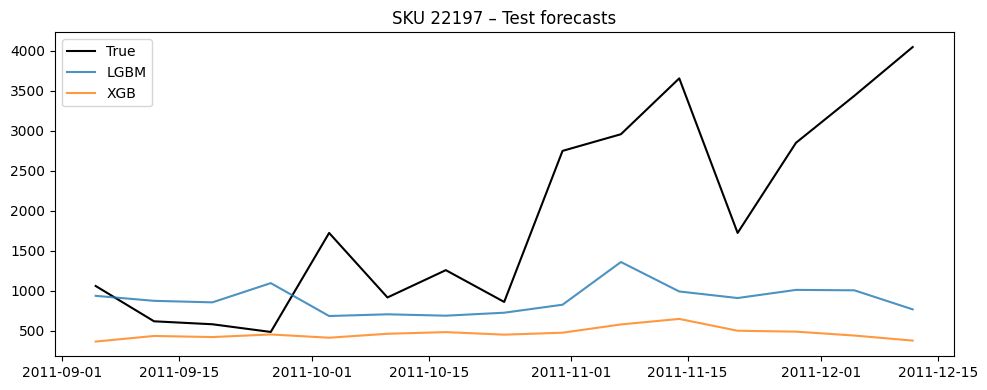

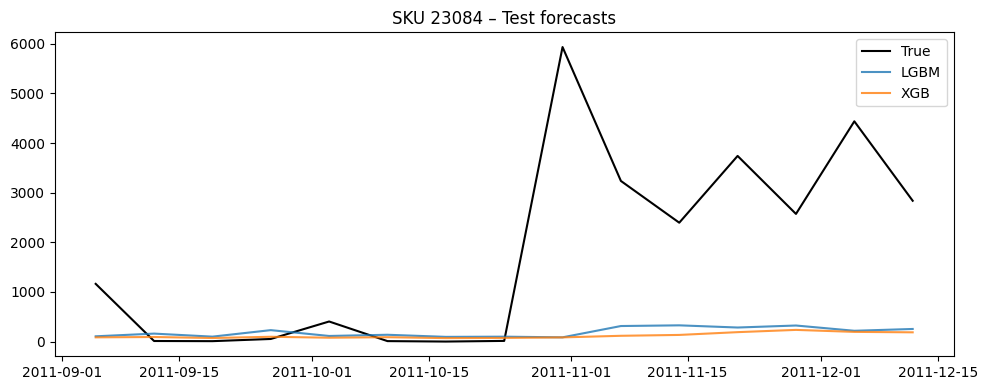

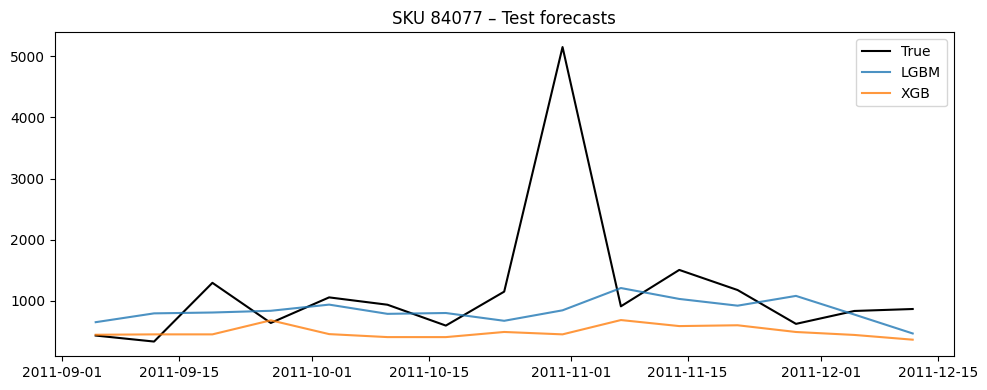

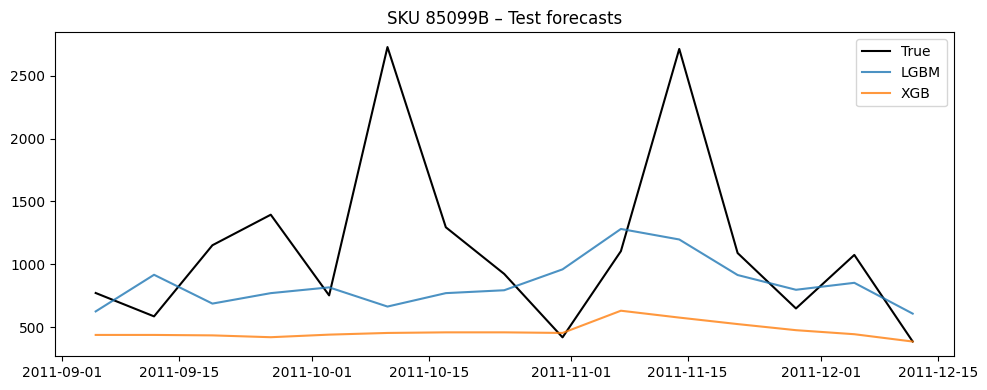

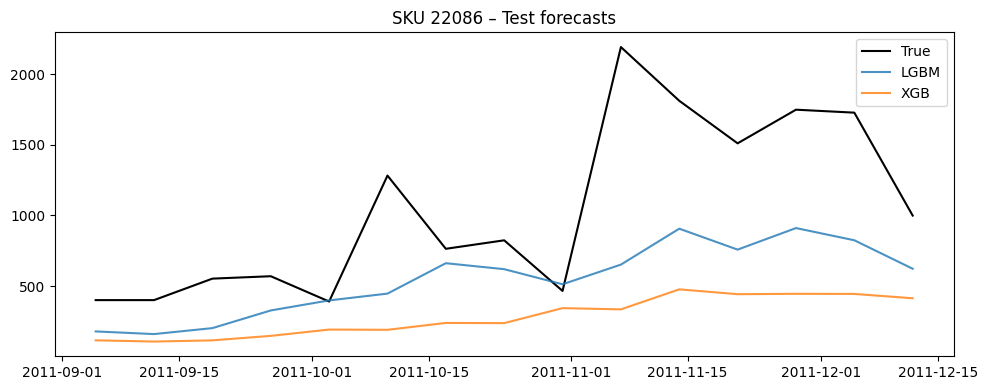

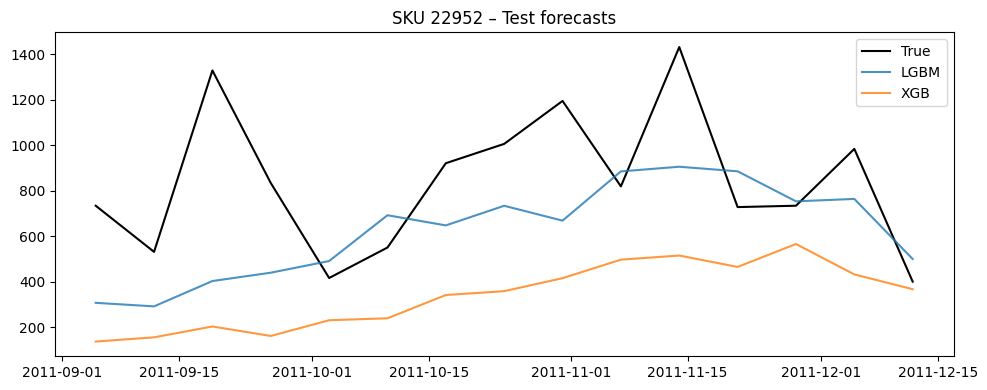

  model        MAE        RMSE      WAPE     SMAPE
0  LGBM  36.723975  108.480459  0.728000  0.895369
1   XGB  48.123691  122.554357  0.953983  0.974360


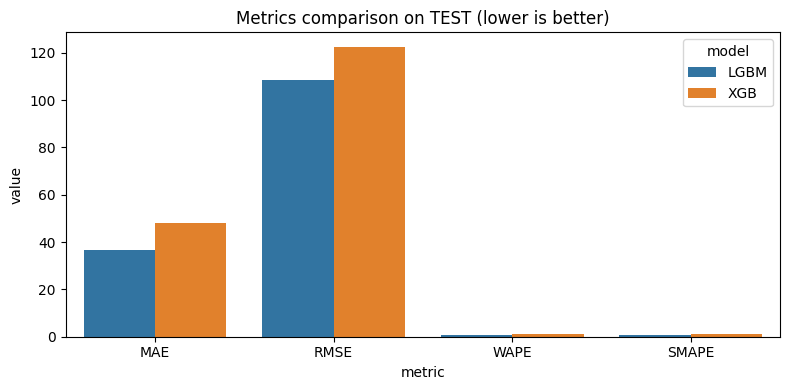

Saved VAL & TEST predictions and metrics


In [32]:
# Metrics comparison and time-series plots (VAL & TEST) 

# Build VAL results for plotting and saving
val_results = pd.DataFrame({
    'InvoiceDate': fe.loc[val_idx, 'InvoiceDate'].values,
    'StockCode': fe.loc[val_idx, 'StockCode'].values,
    'y_true': fe.loc[val_idx, 'y'].values
})
val_results['y_pred_lgb'] = np.where(fe.loc[val_idx, 'label_has_sale'].values==1,
                                     lgb_reg.predict(fe.loc[val_idx, feature_cols]), 0.0)
val_results['y_pred_xgb'] = np.where(fe.loc[val_idx, 'label_has_sale'].values==1,
                                     bst_reg.predict(xgb.DMatrix(fe.loc[val_idx, feature_cols], label=None),
                                                     iteration_range=(0, getattr(bst_reg,'best_iteration', None)+1 if getattr(bst_reg,'best_iteration', None) is not None else None)), 0.0)

# TEST results
true_test_y = fe.loc[test_idx, 'y'].values
results = pd.DataFrame({
    'InvoiceDate': fe.loc[test_idx, 'InvoiceDate'].values,
    'StockCode': fe.loc[test_idx, 'StockCode'].values,
    'y_true': true_test_y,
    'y_pred_lgb': y_pred_lgb,
    'y_pred_xgb': y_pred_xgb
})

# Reports (test)
rep_lgb = regression_report(results['y_true'], results['y_pred_lgb'])
rep_xgb = regression_report(results['y_true'], results['y_pred_xgb'])
print('LGBM:', rep_lgb)
print('XGB :', rep_xgb)

# Time-series plots for a few SKUs on TEST
plot_skus = results.groupby('StockCode')['y_true'].sum().sort_values(ascending=False).head(6).index
for sku in plot_skus:
    g = results[results['StockCode']==sku].sort_values('InvoiceDate')
    plt.figure(figsize=(10,4))
    plt.plot(g['InvoiceDate'], g['y_true'], label='True', color='black')
    plt.plot(g['InvoiceDate'], g['y_pred_lgb'], label='LGBM', alpha=0.8)
    plt.plot(g['InvoiceDate'], g['y_pred_xgb'], label='XGB', alpha=0.8)
    plt.title(f'SKU {sku} – Test forecasts')
    plt.legend(); plt.tight_layout(); plt.show()

# Summary bar plot (test)
summary = pd.DataFrame([
    {'model':'LGBM', **rep_lgb},
    {'model':'XGB', **rep_xgb},
])
print(summary)
plt.figure(figsize=(8,4))
sns.barplot(data=summary.melt(id_vars='model', var_name='metric', value_name='value'), x='metric', y='value', hue='model')
plt.title('Metrics comparison on TEST (lower is better)')
plt.xticks(rotation=0)
plt.tight_layout(); plt.show()

# Save VAL & TEST for plotting later
val_results.to_csv(PRED_DIR / 'val_predictions_lgb_xgb.csv', index=False)
results.to_csv(PRED_DIR / 'test_predictions_lgb_xgb.csv', index=False)
summary.to_csv(PRED_DIR / 'metrics_summary.csv', index=False)
print('Saved VAL & TEST predictions and metrics')


Validation set analysis:
y_val_cls distribution: [15602 23931]
LGBM predictions distribution: [16708 22825]
XGB predictions distribution: [16504 23029]
LGBM probability range: 0.0553 - 0.9916
XGB probability range: 0.0117 - 0.9978

Test set analysis:
y_test_cls distribution: [10495 32889]
LGBM test predictions distribution: [11398 31986]
XGB test predictions distribution: [10999 32385]
LGBM test probability range: 0.0558 - 0.9916
XGB test probability range: 0.0130 - 0.9976

Classification metrics:
  split model  accuracy  precision    recall        f1
0   val  LGBM  0.795158   0.846835  0.807697  0.826803
1   val   XGB  0.797030   0.845369  0.813505  0.829131
2  test  LGBM  0.834616   0.901957  0.877193  0.889403
3  test   XGB  0.835976   0.897916  0.884156  0.890983

Confusion matrices:

VAL set:
LGBM confusion matrix:
[[12106  3496]
 [ 4602 19329]]
XGB confusion matrix:
[[12041  3561]
 [ 4463 19468]]

TEST set:
LGBM confusion matrix:
[[ 7359  3136]
 [ 4039 28850]]
XGB confusion matri

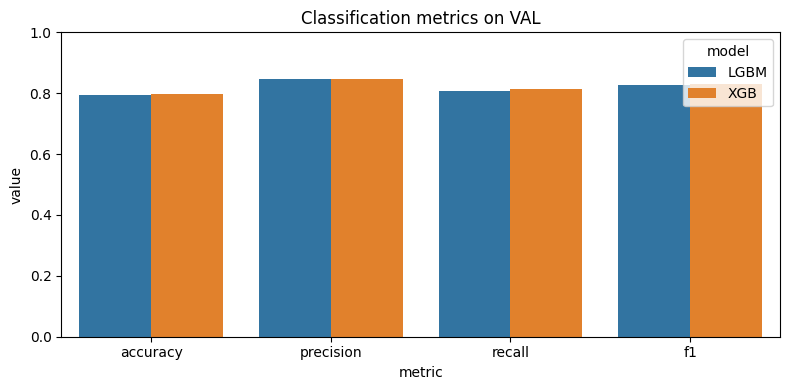

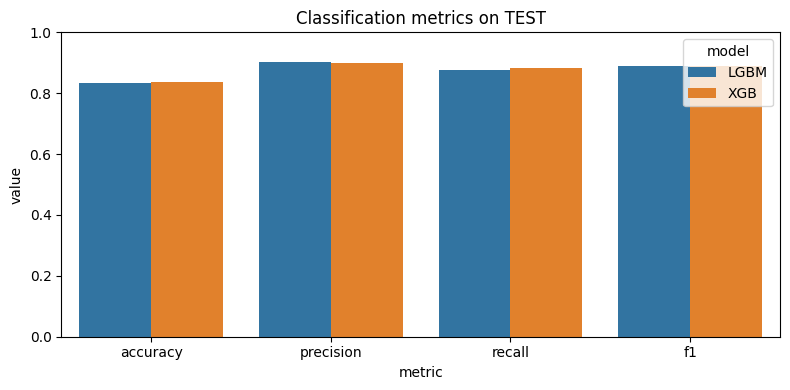

Saved classification metrics summary


In [33]:
# Classification metrics (val & test): accuracy, precision, recall, f1

# Build val classifiers' predictions
val_cls_prob_lgb = lgb_cls.predict_proba(fe.loc[val_idx, feature_cols])[:,1]
val_cls_hat_lgb = (val_cls_prob_lgb >= 0.5).astype(int)

val_cls_prob_xgb = bst_cls.predict(xgb.DMatrix(fe.loc[val_idx, feature_cols]),
                                   iteration_range=(0, getattr(bst_cls,'best_iteration', None)+1 if getattr(bst_cls,'best_iteration', None) is not None else None))
val_cls_hat_xgb = (val_cls_prob_xgb >= 0.5).astype(int)

# Debug: Check the distribution of predictions and ground truth
print("Validation set analysis:")
print(f"y_val_cls distribution: {np.bincount(y_val_cls)}")
print(f"LGBM predictions distribution: {np.bincount(val_cls_hat_lgb)}")
print(f"XGB predictions distribution: {np.bincount(val_cls_hat_xgb)}")
print(f"LGBM probability range: {val_cls_prob_lgb.min():.4f} - {val_cls_prob_lgb.max():.4f}")
print(f"XGB probability range: {val_cls_prob_xgb.min():.4f} - {val_cls_prob_xgb.max():.4f}")

# Use y_val_cls ground truth
metrics_rows = []
for model, yhat in [('LGBM', val_cls_hat_lgb), ('XGB', val_cls_hat_xgb)]:
    metrics_rows.append({'split':'val','model':model,
                         'accuracy': accuracy_score(y_val_cls, yhat),
                         'precision': precision_score(y_val_cls, yhat, zero_division=0),
                         'recall': recall_score(y_val_cls, yhat, zero_division=0),
                         'f1': f1_score(y_val_cls, yhat, zero_division=0)})

# Test classifiers' predictions were computed earlier
test_cls_hat_lgb = (y_prob_lgb >= 0.5).astype(int)
test_cls_hat_xgb = (prob_xgb >= 0.5).astype(int)

# Debug: Check the distribution of test predictions and ground truth
print("\nTest set analysis:")
print(f"y_test_cls distribution: {np.bincount(y_test_cls)}")
print(f"LGBM test predictions distribution: {np.bincount(test_cls_hat_lgb)}")
print(f"XGB test predictions distribution: {np.bincount(test_cls_hat_xgb)}")
print(f"LGBM test probability range: {y_prob_lgb.min():.4f} - {y_prob_lgb.max():.4f}")
print(f"XGB test probability range: {prob_xgb.min():.4f} - {prob_xgb.max():.4f}")

for model, yhat in [('LGBM', test_cls_hat_lgb), ('XGB', test_cls_hat_xgb)]:
    metrics_rows.append({'split':'test','model':model,
                         'accuracy': accuracy_score(y_test_cls, yhat),
                         'precision': precision_score(y_test_cls, yhat, zero_division=0),
                         'recall': recall_score(y_test_cls, yhat, zero_division=0),
                         'f1': f1_score(y_test_cls, yhat, zero_division=0)})

clf_summary = pd.DataFrame(metrics_rows)
print("\nClassification metrics:")
print(clf_summary)

# Additional debugging: Check confusion matrices
print("\nConfusion matrices:")
for split, y_true, models_preds in [
    ('val', y_val_cls, [('LGBM', val_cls_hat_lgb), ('XGB', val_cls_hat_xgb)]),
    ('test', y_test_cls, [('LGBM', test_cls_hat_lgb), ('XGB', test_cls_hat_xgb)])
]:
    print(f"\n{split.upper()} set:")
    for model, y_pred in models_preds:
        cm = confusion_matrix(y_true, y_pred)
        print(f"{model} confusion matrix:\n{cm}")

# Plot grouped bars per split
for split in ['val','test']:
    dfp = clf_summary[clf_summary['split']==split].melt(id_vars=['split','model'],
                                                        value_vars=['accuracy','precision','recall','f1'],
                                                        var_name='metric', value_name='value')
    plt.figure(figsize=(8,4))
    sns.barplot(data=dfp, x='metric', y='value', hue='model')
    plt.ylim(0,1)
    plt.title(f'Classification metrics on {split.upper()}')
    plt.tight_layout(); plt.show()

# Save classification metrics
clf_summary.to_csv(PRED_DIR / 'classification_metrics_summary.csv', index=False)
print('Saved classification metrics summary')


In [34]:
# --- Auto-detect important columns from `fe` ---
import pandas as pd

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# đoán tên cột theo các tên thường gặp
DATE_COL   = pick_col(fe, ['InvoiceDate','week','Week','Date','date','ds'])
SKU_COL    = pick_col(fe, ['StockCode','sku','SKU','item_id'])
TARGET_COL = pick_col(fe, ['Quantity','qty','y','target','gross','units'])  # mục tiêu hồi quy

# tạo nhãn phân loại nếu chưa có: "có bán?" (has_sale)
CLS_COL = 'has_sale'
if CLS_COL not in fe.columns:
    assert TARGET_COL is not None, "Không tìm thấy cột mục tiêu (ví dụ Quantity/qty)."
    fe[CLS_COL] = (fe[TARGET_COL] > 0).astype(int)

# kiểm tra tối thiểu
assert DATE_COL is not None,  "Không tìm thấy cột ngày/tuần (InvoiceDate/week/date/ds)."
assert SKU_COL  is not None,  "Không tìm thấy cột SKU (StockCode/sku/...)."
assert TARGET_COL is not None, "Không tìm thấy cột mục tiêu (Quantity/qty/...)."

print("DATE_COL:", DATE_COL, "| SKU_COL:", SKU_COL, "| TARGET_COL:", TARGET_COL, "| CLS_COL:", CLS_COL)

# 1) Rà soát & loại bỏ các cột rò rỉ khỏi feature_cols
CLS_COL = "has_sale"        # đổi theo tên nhãn phân loại thực tế của bạn
LEAK_PATTERNS = ("has_sale", "y_cls", "is_sale", "target", "qty_0", "qty_t",
                 "revenue_t", "gross_t", "cur_", "_t0", "_tcur")

drop_strict = {DATE_COL, "split", TARGET_COL, CLS_COL}
feature_cols = [c for c in feature_cols
                if c not in drop_strict
                and not any(p in c for p in LEAK_PATTERNS)]

assert CLS_COL not in feature_cols, "Nhãn đang nằm trong feature_cols!"
assert TARGET_COL not in feature_cols, "Target hồi quy đang nằm trong feature_cols!"

# 2) Sanity check: tìm feature “đáng ngờ” tương quan hoàn hảo với nhãn
from sklearn.metrics import roc_auc_score
sus = []
for c in feature_cols:
    x = fe.loc[val_idx, c]
    if x.isna().all(): 
        continue
    try:
        auc = roc_auc_score(y_val_cls, x.fillna(x.median()))
        if auc > 0.999 or auc < 0.001:   # quá hoàn hảo -> rò rỉ
            sus.append((c, auc))
    except ValueError:
        pass
print("Suspicious features (AUC≈1):", sus[:20])

# 3) Đảm bảo các feature thời gian đều là quá khứ (≤ t-1)
# Ví dụ: nếu có các cột roll/zero_rate/... ở 't', hãy chỉ dùng bản '_lag1' hoặc tính rolling.shift(1)

# 4) Đảm bảo dự đoán đúng split
val_X = fe.loc[val_idx, feature_cols]
test_X = fe.loc[test_idx, feature_cols]
val_y  = y_val_cls
test_y = y_test_cls

val_cls_prob_lgb  = lgb_cls.predict_proba(val_X)[:, 1]
test_cls_prob_lgb = lgb_cls.predict_proba(test_X)[:, 1]

val_cls_prob_xgb  = bst_cls.predict(xgb.DMatrix(val_X),
                                    iteration_range=(0, (getattr(bst_cls,'best_iteration', None) or 0) + 1))
test_cls_prob_xgb = bst_cls.predict(xgb.DMatrix(test_X),
                                    iteration_range=(0, (getattr(bst_cls,'best_iteration', None) or 0) + 1))

# 5) Ngưỡng dự báo phù hợp mất cân bằng (tùy chọn)
thr = 0.3  # thử nhỏ hơn 0.5 nếu lớp 1 hiếm
val_hat_lgb  = (val_cls_prob_lgb  >= thr).astype(int)
test_hat_lgb = (test_cls_prob_lgb >= thr).astype(int)
val_hat_xgb  = (val_cls_prob_xgb  >= thr).astype(int)
test_hat_xgb = (test_cls_prob_xgb >= thr).astype(int)


DATE_COL: InvoiceDate | SKU_COL: StockCode | TARGET_COL: Quantity | CLS_COL: has_sale
Suspicious features (AUC≈1): []


In [35]:
# Regularized models: add stronger regularization and compare with baseline

# --- LightGBM (regularized) ---
lgb_cls_r = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.7,
    bagging_fraction=0.7,
    bagging_freq=1,
    min_child_samples=100,
    reg_alpha=0.1,
    reg_lambda=2.0,
    random_state=42,
)

lgb_reg_r = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=63,
    feature_fraction=0.7,
    bagging_fraction=0.7,
    bagging_freq=1,
    min_child_samples=100,
    reg_alpha=0.1,
    reg_lambda=2.0,
    random_state=42,
)

lgb_cls_r.fit(X_train, y_train_cls,
              eval_set=[(X_val, y_val_cls)],
              eval_metric='binary_logloss',
              callbacks=[lgb.early_stopping(100)])

lgb_reg_r.fit(X_train_reg, y_train_reg,
              eval_set=[(X_val_reg, y_val_reg)],
              eval_metric='l2',
              callbacks=[lgb.early_stopping(150)])

# Predictions (VAL/TEST)
val_prob_lgb_r = lgb_cls_r.predict_proba(X_val)[:,1]
val_hat_lgb_r  = (val_prob_lgb_r >= 0.5).astype(int)

y_prob_lgb_r   = lgb_cls_r.predict_proba(X_test)[:,1]
y_hat_lgb_r    = (y_prob_lgb_r >= 0.5).astype(int)

val_pred_lgb_r = np.where(val_hat_lgb_r==1, np.maximum(0.0, lgb_reg_r.predict(X_val)), 0.0)
y_pred_lgb_r   = np.where(y_hat_lgb_r==1,  np.maximum(0.0, lgb_reg_r.predict(X_test)), 0.0)

# --- XGBoost (regularized) ---
dtrain_cls_r = xgb.DMatrix(X_train, label=y_train_cls)
dval_cls_r   = xgb.DMatrix(X_val,   label=y_val_cls)
dtest_cls_r  = xgb.DMatrix(X_test)

params_cls_r = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 5,
    'gamma': 1.0,
    'reg_alpha': 0.1,
    'reg_lambda': 2.0,
    'tree_method': 'hist',
    'seed': 42,
}

bst_cls_r = xgb.train(params_cls_r, dtrain_cls_r, num_boost_round=2000,
                      evals=[(dval_cls_r,'valid')], early_stopping_rounds=100, verbose_eval=False)

# Regressor
pos_train_dm = xgb.DMatrix(X_train_reg, label=y_train_reg)
pos_val_dm   = xgb.DMatrix(X_val_reg,   label=y_val_reg)
pos_test_dm  = xgb.DMatrix(X_test)

params_reg_r = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.03,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 5,
    'gamma': 1.0,
    'reg_alpha': 0.1,
    'reg_lambda': 2.0,
    'tree_method': 'hist',
    'seed': 42,
}

bst_reg_r = xgb.train(params_reg_r, pos_train_dm, num_boost_round=3000,
                      evals=[(pos_val_dm,'valid')], early_stopping_rounds=150, verbose_eval=False)

# Predictions (VAL/TEST) - Fix broadcasting issue by filtering positive samples for regression
val_prob_xgb_r = bst_cls_r.predict(dval_cls_r, iteration_range=(0, (bst_cls_r.best_iteration or 0)+1))
val_hat_xgb_r  = (val_prob_xgb_r >= 0.5).astype(int)

prob_xgb_r     = bst_cls_r.predict(dtest_cls_r, iteration_range=(0, (bst_cls_r.best_iteration or 0)+1))
y_hat_xgb_r    = (prob_xgb_r >= 0.5).astype(int)

# Create DMatrix for validation/test predictions only on positive classification samples
val_pos_mask_r = val_hat_xgb_r == 1
test_pos_mask_r = y_hat_xgb_r == 1

# Initialize predictions with zeros
val_pred_xgb_r = np.zeros(len(val_hat_xgb_r))
y_pred_xgb_r = np.zeros(len(y_hat_xgb_r))

# Only predict regression for positive samples
if val_pos_mask_r.sum() > 0:
    val_pos_dm_pred = xgb.DMatrix(X_val[val_pos_mask_r])
    val_pred_xgb_r[val_pos_mask_r] = np.maximum(0.0, bst_reg_r.predict(val_pos_dm_pred, iteration_range=(0, (bst_reg_r.best_iteration or 0)+1)))

if test_pos_mask_r.sum() > 0:
    test_pos_dm_pred = xgb.DMatrix(X_test[test_pos_mask_r])
    y_pred_xgb_r[test_pos_mask_r] = np.maximum(0.0, bst_reg_r.predict(test_pos_dm_pred, iteration_range=(0, (bst_reg_r.best_iteration or 0)+1)))

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 140761, number of negative: 105110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data 

Classification compare:
   split      model  accuracy  precision    recall        f1
0   val  LGBM_base  0.795158   0.846835  0.807697  0.826803
1   val   LGBM_reg  0.794906   0.847407  0.806402  0.826396
2   val   XGB_base  0.797030   0.845369  0.813505  0.829131
3   val    XGB_reg  0.796373   0.844984  0.812712  0.828534
4  test  LGBM_base  0.834616   0.901957  0.877193  0.889403
5  test   LGBM_reg  0.834132   0.901792  0.876676  0.889057
6  test   XGB_base  0.835976   0.897916  0.884156  0.890983
7  test    XGB_reg  0.836253   0.897978  0.884490  0.891183
Regression compare (TEST):
        model        MAE        RMSE      WAPE     SMAPE
0  LGBM_base  36.723975  108.480459  0.728000  0.895369
1   LGBM_reg  35.721237  106.100094  0.708122  0.869907
2   XGB_base  48.123691  122.554357  0.953983  0.974360
3    XGB_reg  51.798906  125.122842  1.026839  0.953892

Main Regression Metrics (MAE, RMSE):
        model        MAE        RMSE
0  LGBM_base  36.723975  108.480459
1   LGBM_reg  35

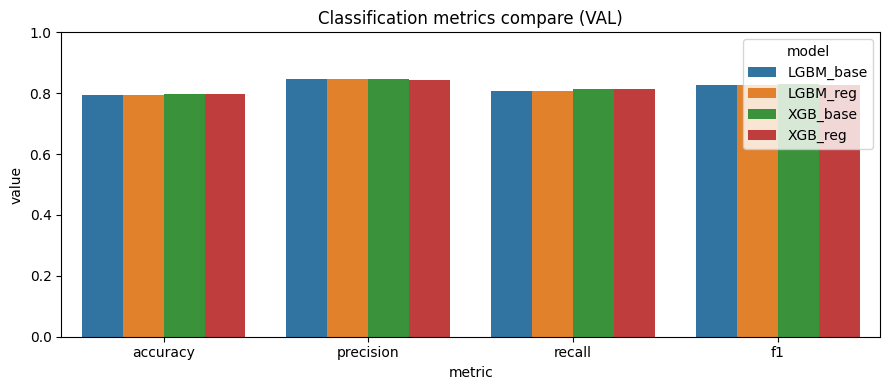

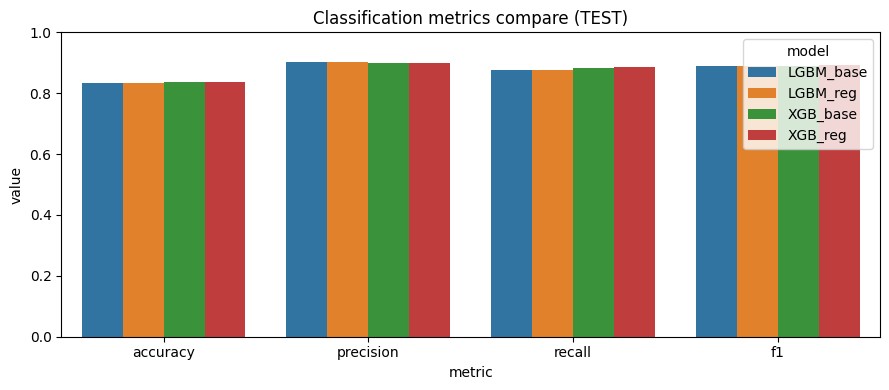

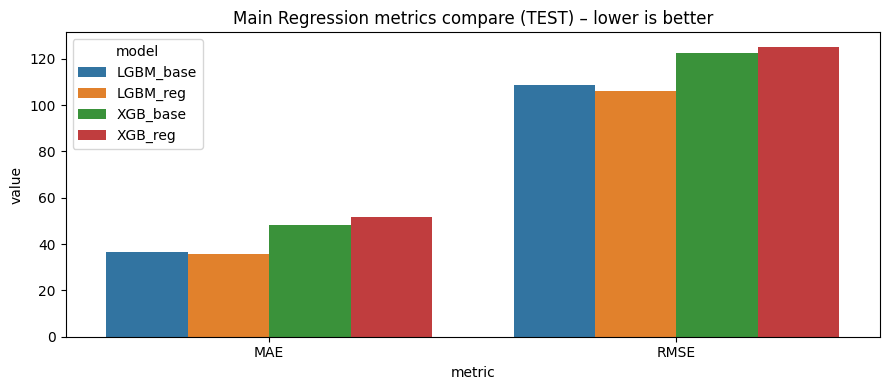

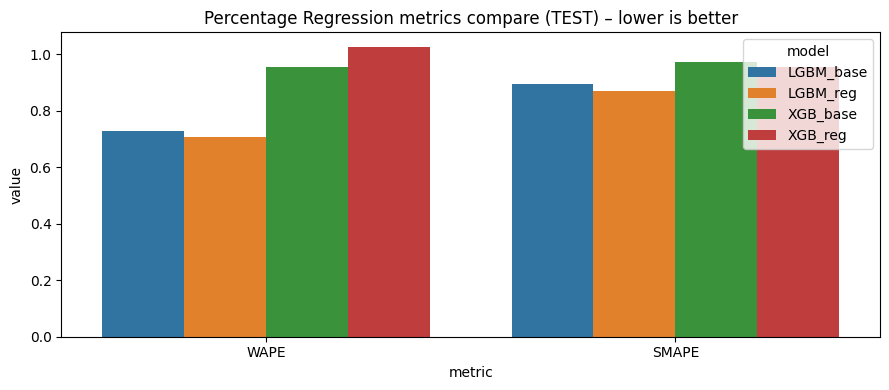

Saved comparison CSVs


In [36]:
# --- Compare classification metrics (VAL/TEST) ---
clf_compare_rows = []
for split, y_true, hats in [
    ('val',  y_val_cls,  [('LGBM_base', (lgb_cls.predict_proba(X_val)[:,1] >= 0.5).astype(int)),
                          ('LGBM_reg',  val_hat_lgb_r),
                          ('XGB_base',  (bst_cls.predict(dval_cls, iteration_range=(0, (bst_cls.best_iteration or 0)+1)) >= 0.5).astype(int)),
                          ('XGB_reg',   val_hat_xgb_r)]),
    ('test', y_test_cls, [('LGBM_base', (y_prob_lgb >= 0.5).astype(int)),
                          ('LGBM_reg',  y_hat_lgb_r),
                          ('XGB_base',  (prob_xgb >= 0.5).astype(int)),
                          ('XGB_reg',   y_hat_xgb_r)])
]:
    for model, yhat in hats:
        clf_compare_rows.append({
            'split': split,
            'model': model,
            'accuracy':  accuracy_score(y_true, yhat),
            'precision': precision_score(y_true, yhat, zero_division=0),
            'recall':    recall_score(y_true, yhat, zero_division=0),
            'f1':        f1_score(y_true, yhat, zero_division=0),
        })

clf_compare = pd.DataFrame(clf_compare_rows)
print('Classification compare:\n', clf_compare)

# --- Compare regression metrics on TEST ---
reg_compare = pd.DataFrame([
    {'model':'LGBM_base', **regression_report(results['y_true'], y_pred_lgb)},
    {'model':'LGBM_reg',  **regression_report(results['y_true'], y_pred_lgb_r)},
    {'model':'XGB_base',  **regression_report(results['y_true'], y_pred_xgb)},
    {'model':'XGB_reg',   **regression_report(results['y_true'], y_pred_xgb_r)},
])
print('Regression compare (TEST):\n', reg_compare)

# Separate metrics with different scales
reg_compare_main = reg_compare[['model', 'MAE', 'RMSE']].copy()
reg_compare_percentage = reg_compare[['model', 'WAPE', 'SMAPE']].copy()

print('\nMain Regression Metrics (MAE, RMSE):\n', reg_compare_main)
print('\nPercentage Regression Metrics (WAPE, SMAPE):\n', reg_compare_percentage)

# Plots
for split in ['val','test']:
    dfp = clf_compare[clf_compare['split']==split].melt(id_vars=['split','model'],
                                                        value_vars=['accuracy','precision','recall','f1'],
                                                        var_name='metric', value_name='value')
    plt.figure(figsize=(9,4))
    sns.barplot(data=dfp, x='metric', y='value', hue='model')
    plt.ylim(0,1)
    plt.title(f'Classification metrics compare ({split.upper()})')
    plt.tight_layout(); plt.show()

# Plot main regression metrics (MAE, RMSE)
plt.figure(figsize=(9,4))
sns.barplot(data=reg_compare_main.melt(id_vars='model', var_name='metric', value_name='value'),
            x='metric', y='value', hue='model')
plt.title('Main Regression metrics compare (TEST) – lower is better')
plt.tight_layout(); plt.show()

# Plot percentage regression metrics (WAPE, SMAPE)
plt.figure(figsize=(9,4))
sns.barplot(data=reg_compare_percentage.melt(id_vars='model', var_name='metric', value_name='value'),
            x='metric', y='value', hue='model')
plt.title('Percentage Regression metrics compare (TEST) – lower is better')
plt.tight_layout(); plt.show()

# Save
clf_compare.to_csv(PRED_DIR / 'classification_metrics_comparison_regularized.csv', index=False)
reg_compare.to_csv(PRED_DIR / 'regression_metrics_comparison_regularized.csv', index=False)
reg_compare_main.to_csv(PRED_DIR / 'regression_main_metrics_comparison_regularized.csv', index=False)
reg_compare_percentage.to_csv(PRED_DIR / 'regression_percentage_metrics_comparison_regularized.csv', index=False)
print('Saved comparison CSVs')


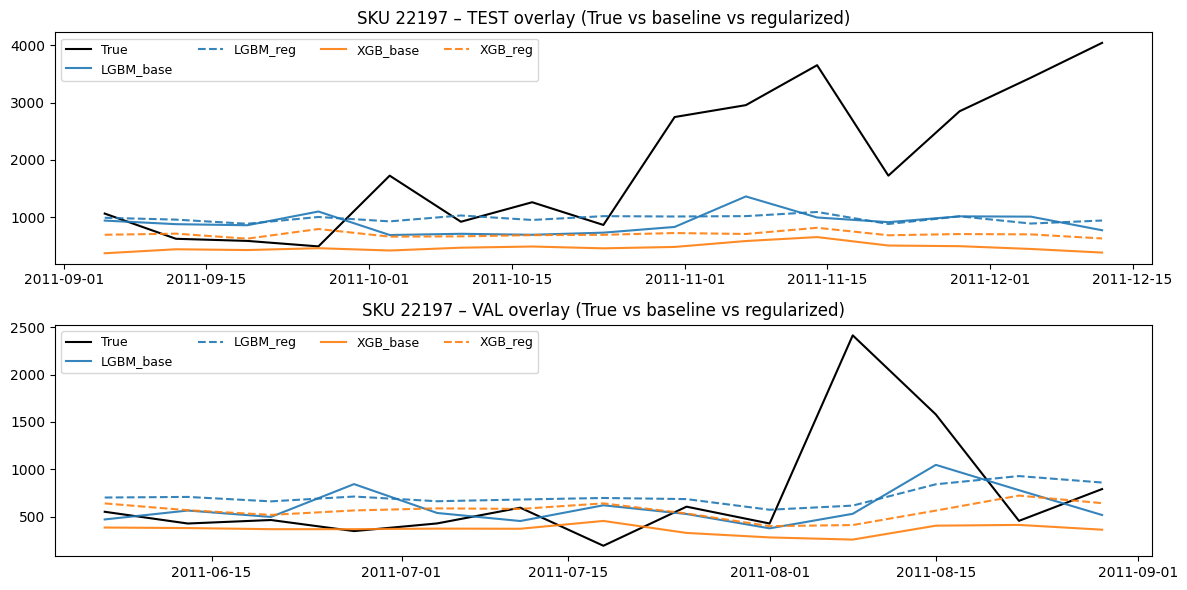

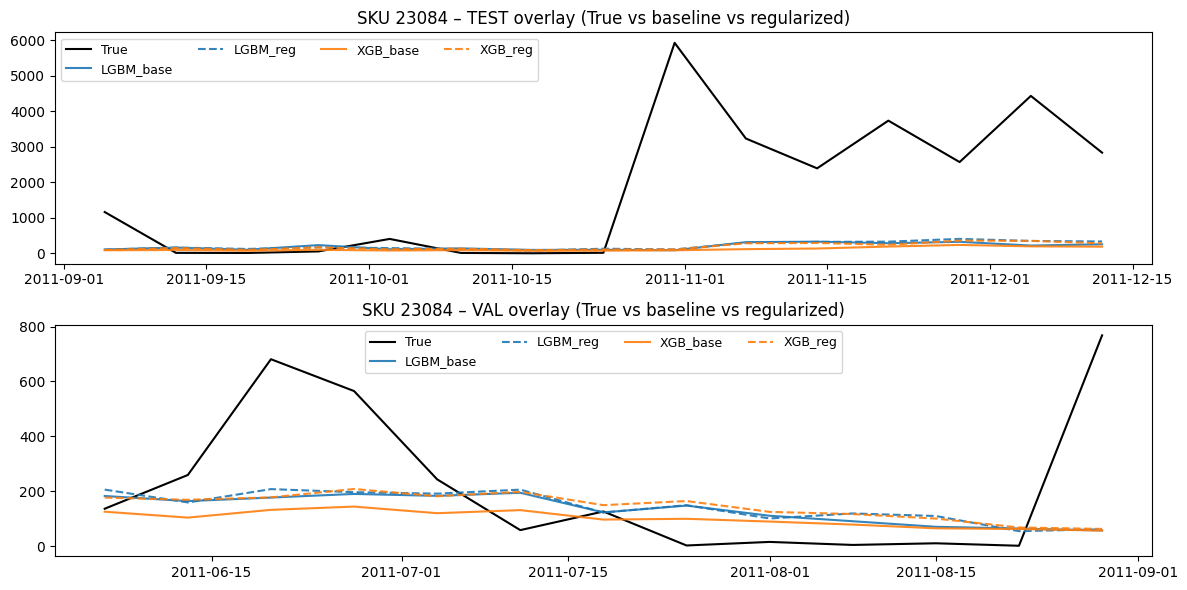

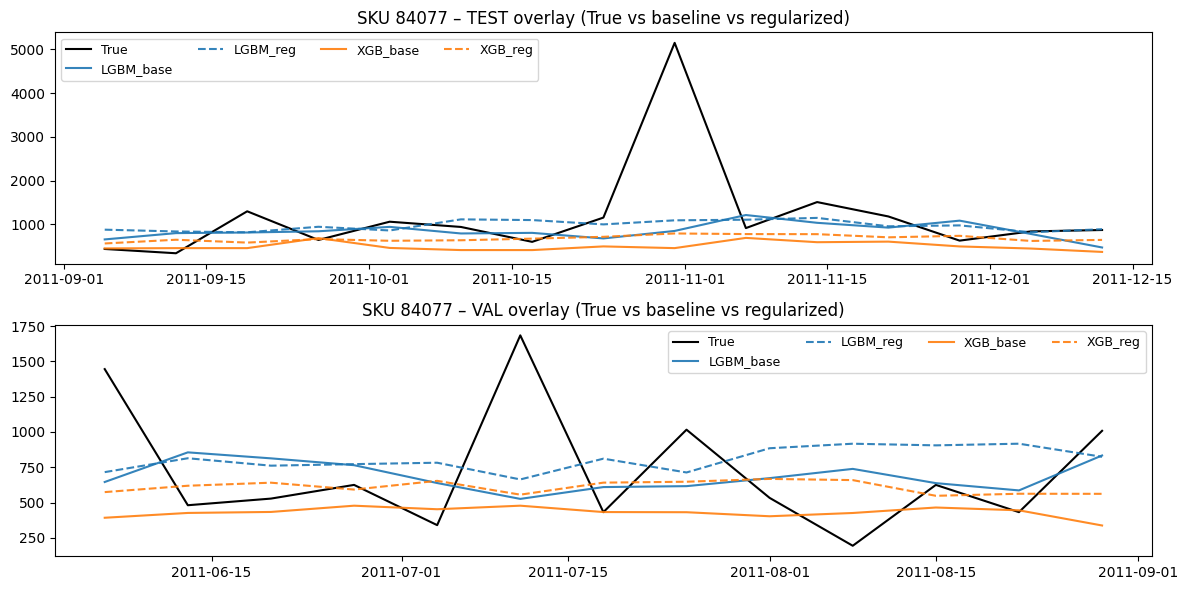

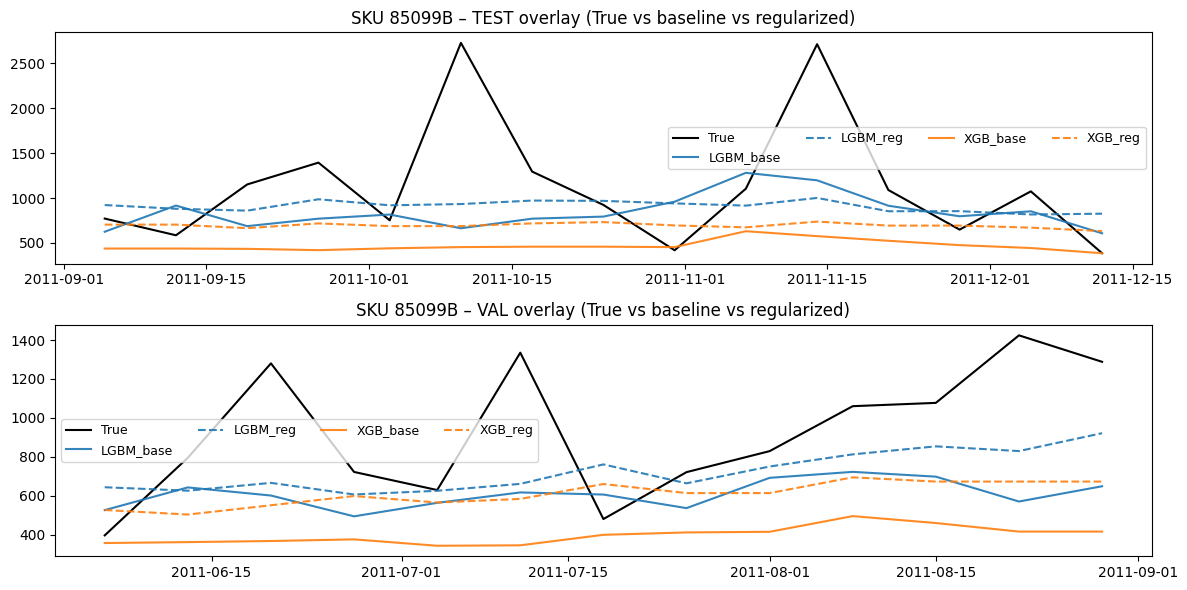

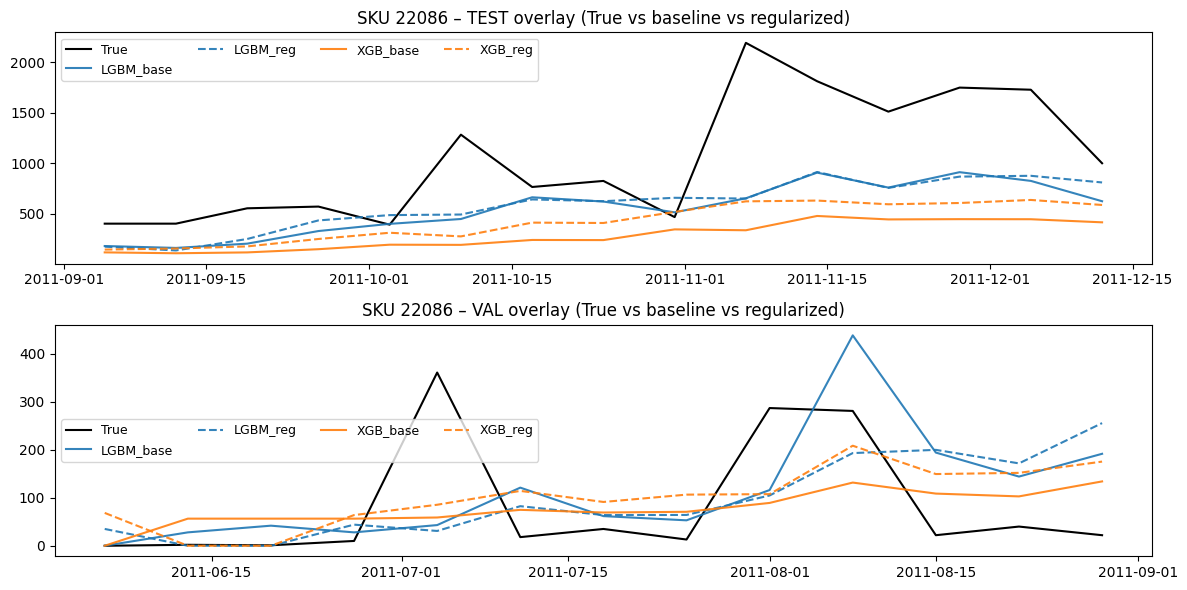

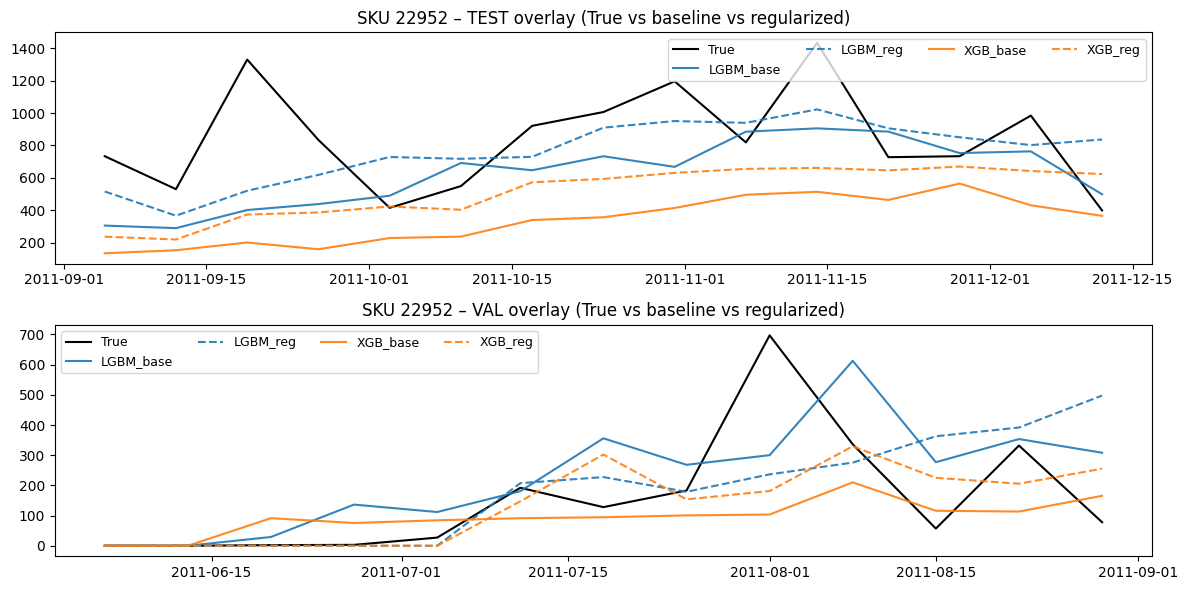

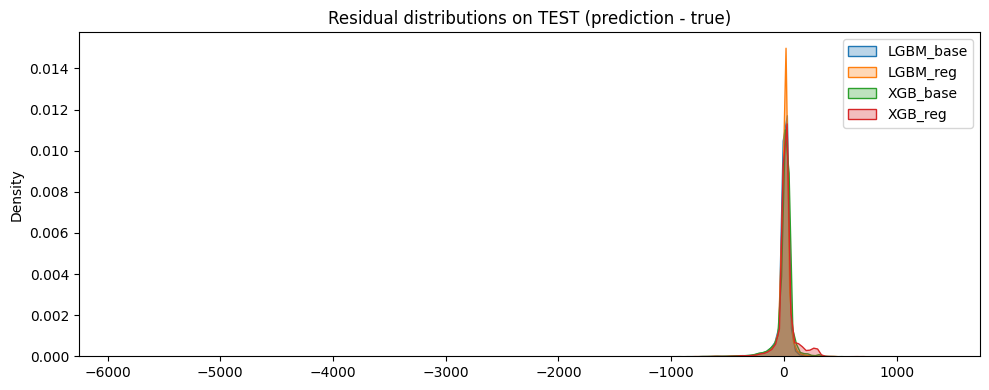

In [37]:
# Visual comparison plots – baseline vs regularized (VAL & TEST)

# Attach regularized predictions to frames for easy slicing
if 'y_pred_lgb_r' in globals() and 'y_pred_xgb_r' in globals():
    results_ext = results.copy()
    results_ext['y_pred_lgb_r'] = y_pred_lgb_r
    results_ext['y_pred_xgb_r'] = y_pred_xgb_r
else:
    results_ext = results.copy()

if 'val_pred_lgb_r' in globals() and 'val_pred_xgb_r' in globals():
    val_results_ext = val_results.copy()
    val_results_ext['y_pred_lgb_r'] = val_pred_lgb_r
    val_results_ext['y_pred_xgb_r'] = val_pred_xgb_r
else:
    val_results_ext = val_results.copy()

# Pick top SKUs by test volume
plot_skus = results_ext.groupby('StockCode')['y_true'].sum().sort_values(ascending=False).head(6).index

for sku in plot_skus:
    gt = results_ext[results_ext['StockCode']==sku].sort_values('InvoiceDate')
    gv = val_results_ext[val_results_ext['StockCode']==sku].sort_values('InvoiceDate')

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

    # TEST overlay
    ax = axes[0]
    ax.plot(gt['InvoiceDate'], gt['y_true'], color='black', label='True')
    ax.plot(gt['InvoiceDate'], gt['y_pred_lgb'], color='#1f77b4', alpha=0.9, label='LGBM_base')
    if 'y_pred_lgb_r' in gt:
        ax.plot(gt['InvoiceDate'], gt['y_pred_lgb_r'], color='#1f77b4', linestyle='--', alpha=0.9, label='LGBM_reg')
    ax.plot(gt['InvoiceDate'], gt['y_pred_xgb'], color='#ff7f0e', alpha=0.9, label='XGB_base')
    if 'y_pred_xgb_r' in gt:
        ax.plot(gt['InvoiceDate'], gt['y_pred_xgb_r'], color='#ff7f0e', linestyle='--', alpha=0.9, label='XGB_reg')
    ax.set_title(f'SKU {sku} – TEST overlay (True vs baseline vs regularized)')
    ax.legend(ncol=4, fontsize=9)

    # VAL overlay
    ax = axes[1]
    ax.plot(gv['InvoiceDate'], gv['y_true'], color='black', label='True')
    ax.plot(gv['InvoiceDate'], gv['y_pred_lgb'], color='#1f77b4', alpha=0.9, label='LGBM_base')
    if 'y_pred_lgb_r' in gv:
        ax.plot(gv['InvoiceDate'], gv['y_pred_lgb_r'], color='#1f77b4', linestyle='--', alpha=0.9, label='LGBM_reg')
    ax.plot(gv['InvoiceDate'], gv['y_pred_xgb'], color='#ff7f0e', alpha=0.9, label='XGB_base')
    if 'y_pred_xgb_r' in gv:
        ax.plot(gv['InvoiceDate'], gv['y_pred_xgb_r'], color='#ff7f0e', linestyle='--', alpha=0.9, label='XGB_reg')
    ax.set_title(f'SKU {sku} – VAL overlay (True vs baseline vs regularized)')
    ax.legend(ncol=4, fontsize=9)

    plt.tight_layout(); plt.show()

# Optional: residual distributions on TEST
if 'y_pred_lgb_r' in results_ext and 'y_pred_xgb_r' in results_ext:
    plt.figure(figsize=(10,4))
    sns.kdeplot((results_ext['y_pred_lgb'] - results_ext['y_true']), label='LGBM_base', fill=True, alpha=0.3)
    sns.kdeplot((results_ext['y_pred_lgb_r'] - results_ext['y_true']), label='LGBM_reg',  fill=True, alpha=0.3)
    sns.kdeplot((results_ext['y_pred_xgb'] - results_ext['y_true']), label='XGB_base',   fill=True, alpha=0.3)
    sns.kdeplot((results_ext['y_pred_xgb_r'] - results_ext['y_true']), label='XGB_reg',    fill=True, alpha=0.3)
    plt.title('Residual distributions on TEST (prediction - true)')
    plt.legend(); plt.tight_layout(); plt.show()
